# Photon Nudging of Active Particles

**Frank Cichos, Molecular Nanophotonics Group 2019**

This Notebook describes and plots some basic features of active particles and **photon nudging**. Photon nudging is a technique, which is using the information about the orientation of an active particle in space with respect to a target position to propel or not propel the particle. The particle is thus correlating its activity with its orientation in the lab frame. In its simplest form, the active motion is switched on and off in a binary way. This can be imagined to be a form of vision interaction, i.e. an animal that this only moving towards a target when seeing the target, while it stays passive or undecided about its direction of motion when it is not seeing the target.


![nudging.png](nudging.png)



The work on photon nudging is described in detail in the following publications:

[1]	Qian, B., Montiel, D., Bregulla, A., Cichos, F. & Yang, H. Harnessing thermal fluctuations for purposeful activities: the manipulation of single micro-swimmers by adaptive photon nudging. **Chem Sci 4**, 1420–1429 (2013).

[2]	Bregulla, A. P., Yang, H. & Cichos, F. Stochastic Localization of Microswimmers by Photon Nudging. **ACS Nano 8**, 6542–6550 (2014).

[3]	Selmke, M., Khadka, U., Bregulla, A. P., Cichos, F. & Yang, H. Theory for controlling individual self-propelled micro-swimmers by photon nudging I: directed transport. **Physical Chemistry Chemical Physics 20**, 10502–10520 (2018).

[4]	Selmke, M., Khadka, U., Bregulla, A. P., Cichos, F. & Yang, H. Theory for controlling individual self-propelled micro-swimmers by photon nudging II: confinement. **Physical Chemistry Chemical Physics 20**, 10521–10532 (2018).

[5]	Khadka, U., Holubec, V., Yang, H. & Cichos, F. Active particles bound by information flows. **Nat Commun 9**, 3864 (2018).


In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import randn
from scipy.stats import norm
%config InlineBackend.figure_format = 'retina' 
# this is just for Macbooks to create higher resolution previews of the plots in the notebook

# the lines below set a number of parameters for plotting, such as label font size, 
# title font size, which you may find useful
plt.rcParams.update({'font.size': 12,
                     'axes.titlesize': 16,
                     'axes.labelsize': 16,
                     'axes.labelpad': 14,
                     'lines.linewidth': 1,
                     'lines.markersize': 3,
                     'xtick.labelsize' : 16,
                     'ytick.labelsize' : 16,
                     'xtick.top' : True,
                     'xtick.direction' : 'in',
                     'ytick.right' : True,
                     'ytick.direction' : 'in',}) 


# Table of Contents

* [1. Active Particle Motion](#1.-Active-Particle-Motion)    
    * [1.1 Creating Active Particle Synthetic Data](#1.1-Creating-Active-Particle-Synthetic-Data)  
    * [1.2 Active Particle Displacement Analysis in the Lab Frame](#1.2-Active-Particle-Displacement-Analysis-in-the-Lab-Frame)
        * [Mean Squared Displacement for the Active Particle Motion](#Mean-Squared-Displacement-for-the-Active-Particle-Motion)    
    * [1.3 Active Particle Displacement Analysis in the Particle Frame](#1.3-Active-Particle-Displacement-Analysis-in-the-Particle-Frame)
* [2. Photon Nudging](#2.-Photon-Nudging)
    * [2.1 Photon Nudging Particle Motion in the Lab Frame](#2.1-Photon-Nudging-Particle-Motion-in-the-Lab-Frame)
        * [Setting the Simulation Parameters](#Setting-the-Simulation-Parameters)
        * [Trajectory and Displacement Statistics](#Trajectory-and-Displacement-Statistics)
        * [Mean Squared Displacement](#Mean-Squared-Displacement)
    * [2.2 Nudging Statistics](#2.2-Nudging-Statistics)
    * [2.3 Photon Nudging Density Distributions](#2.3-Photon-Nudging-Density-Distributions)
        * [Effective Radial Velocity](#Effective-Radial-Velocity)
        * [Virtual Effective Potential](#Virtual-Effective-Potential)        
* [3. Artificial Binding of Symmetric Particles](#Artificial-Binding-of-Symmetric-Particles)

## 1. Active Particle Motion

Active particles have in contrast to passive particle in a flow a velocity vector that is fixed in the particles reference frame. The velocity vector is therefore diffusing in its orientation with the particle orientation. Thus if measured in the lab reference frame the particle motion seems random at long time, however, in the particle frame the particle seems to follow a constant flow (see figure below). 

![Trajectory Analysis Sketch](trajectory_analysis_1.png)


### 1.1 Creating Active Particle Synthetic Data

Below are two functions which are used to generate trajectories of active particles that are comtinuously propelled. The first function is used to rotatet a 2D vector in plane by an angle. The second function is the actual trajectory generation function is takes the following parameters and delivers

In [46]:
# translational diffusion coefficient for T=300 K
def D_T(_eta,_R):
    kBT=4.14195e-21 # k_B * 300 K in J
    return(kBT/(6*np.pi*_eta*_R)) # diffusion constant returned in m^2/s

# rotational diffusion coefficient for T=300 K
def D_R(_eta,_R):
    kBT=4.14195e-21 # k_B * 300 K in J
    return(kBT/(8*np.pi*_eta*_R**3)) # diffusion constant returned in m^2/s

In [47]:
# rotate a 2D vector xy by an angle radians
def rotate(xy, radians):
    x, y = xy
    c, s = np.cos(radians), np.sin(radians)
    j = np.matrix([[c, s], [-s, c]])
    m = np.dot(j, [x, y])

    return(float(m.T[0]), float(m.T[1]))

In [48]:
# generate the data of an active particle random walk
def genData_ap(N,_D,_Dr,_v,dt):
    v=np.random.random(2)
    v[0]=_v
    v[1]=0
    sigma=np.sqrt(2*_D*dt)
    sigma_r=np.sqrt(2*_Dr*dt)

    phi=sigma_r*randn(N).cumsum()
    vx,vy=[np.zeros(N),np.zeros(N)]
    vx[:],vy[:]=[v[0],v[1]]
    vv=np.array([rotate([vx[i],vy[i]],phi[i]) for i in range(len(phi))])

    #do the random walk
    x,y=[(sigma*randn(N)+vv[:,0]*dt).cumsum(),(sigma*randn(N)+vv[:,1]*dt).cumsum()]    

    index=[i for i in range(N)]
    df=pd.DataFrame({'x':x,'y':y,'area':np.zeros(N),'max_intensity':np.zeros(N),'frame': index,'angle': phi})
    return(df)

In [722]:
#provide some parameters

dt=0.05  # 50 ms time resolution
v=8   # 10 µm/s velocity
D=D_T(1e-3,0.5e-6)*1e12   # µm^2/s diffusion coefficient
Dr=D_R(1e-3,0.5e-6)   #  rad^2/s rotational diffusion
N=100000 # number of steps


# generate the trajectory and store it in a Pandas DataFrame
dff=genData_ap(N,D,Dr,v,dt)

### 1.2 Active Particle Displacement Analysis in the Lab Frame

The diagrams below plot the trajectory of the active particle as well as the displacement statistics in the lab frame. 
The displacement statistics is obtained 

\begin{equation}
\Delta {\bf r}(\tau)={\bf r}(t_{i}+\tau)-{\bf r}(t_{i})
\end{equation}

from the displacement vector between two snapshots of the particle seperated by the time $\tau$. 
In the case of a normal Brownian motion, the displacement statistics along the x and y-direction would be Gaussian and described by

\begin{equation}
p(\tau)=\frac{1}{\sqrt{2\pi D \tau}}\exp\left(-\frac{x^2}{4D\tau}\right)
\end{equation}

For the active particel in the lab frame, the displacment distributions **are not** anymore Gaussian shaped. In general, they show two distinct maxima. This is due to the fact that either the x or the y-component of the displacement result from $\Delta x=v\cos(\phi)\Delta t$ or $\Delta y=v\sin(\phi)\Delta t$. Thus if the variable $\phi$ is equally distributed, the probability is maximum where the sine or cosine function has zero slope. The peaks are broadened by the noise of the Brownian motion. 


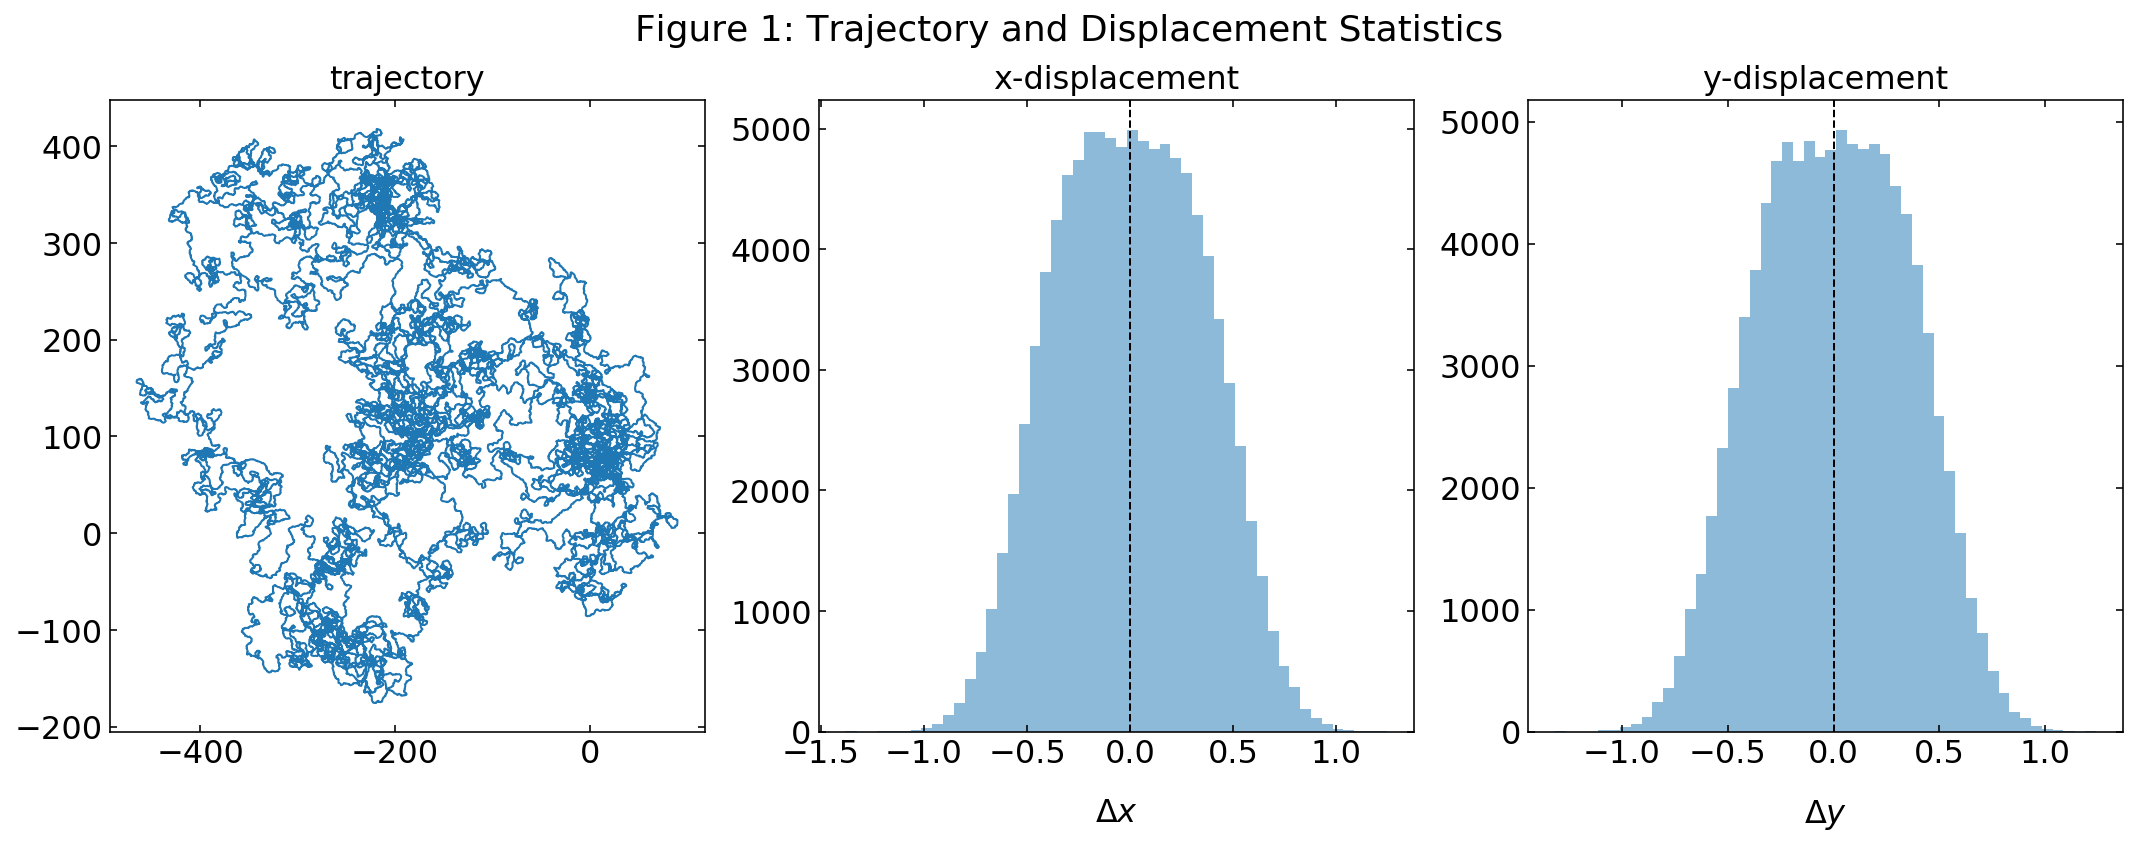

In [723]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.plot(dff['x'],dff['y'],'-')
plt.title('trajectory')

plt.subplot(1,3,2)
dff.x.diff(1).hist(bins=50,alpha=0.5,grid=False)
plt.xlabel('$\Delta x$')
plt.axvline(x=dff.x.diff(1).mean(),ls='--',color='k',lw=1)
plt.title('x-displacement')

plt.subplot(1,3,3)
dff.y.diff(1).hist(bins=50,alpha=0.5,grid=False)
plt.xlabel('$\Delta y$')
plt.axvline(x=dff.y.diff(1).mean(),ls='--',color='k',lw=1)
plt.title('y-displacement')

plt.suptitle('Figure 1: Trajectory and Displacement Statistics',fontsize=18)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

In 2-dimensions the shape of the two above displacement histograms results in the most general case in a donut shaped structure, which is, however, only clearly visible if the displacement in the time $\tau$ due to the propulsion is much larger than the displacement due to Brownian motion.

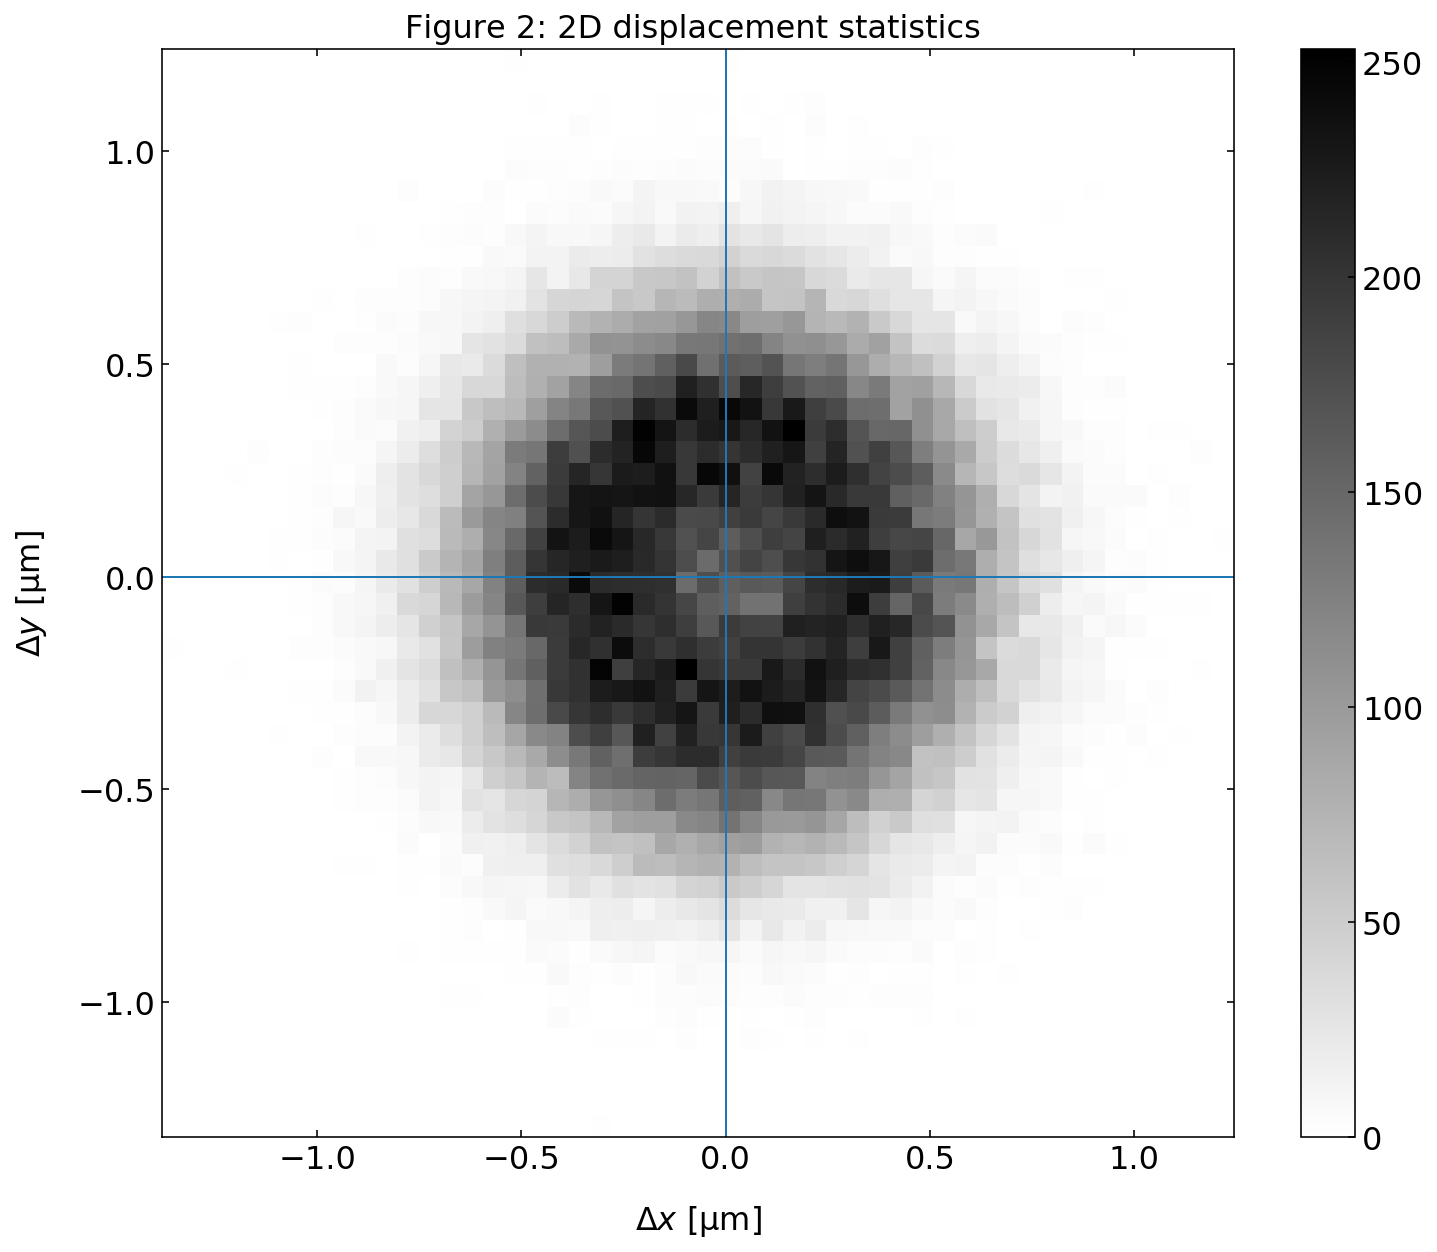

In [724]:
plt.figure(figsize=(12,10))
plt.hist2d(dff.x.diff(1).dropna(),dff.y.diff(1).dropna(),bins=50, cmap='gray_r')
plt.colorbar()
plt.xlabel('$\Delta x$ [µm]')
plt.ylabel('$\Delta y$ [µm]')
plt.axhline(y=0)
plt.axvline(x=0)
plt.title('Figure 2: 2D displacement statistics ')
plt.show()

#### Mean Squared Displacement for the Active Particle Motion

The functions below calculate the mean squared displacement of the active particle motion from the trajectory points and compare this results with the theoretical mean squared displacement given by

\begin{equation}
msd(t)=[4D_{T}+2v_{\rm th}^{2}\tau_{R}] t +2v_{\rm th}^{2}\tau_{R}^{2}[e^{-\frac{t}{\tau_{R}}}-1]
\end{equation}

In [725]:
def msd(_df,_dt,_N=1000):
    msd=np.zeros(_N)
    time=np.array(range(_N))*_dt
    for i in range(_N):
        msd[i]=np.mean(_df.x.diff(i).dropna()**2+np.mean(_df.y.diff(i).dropna()**2))
    return(time,msd)


In [726]:
# calculate the msd
time,MSD=msd(dff,dt)

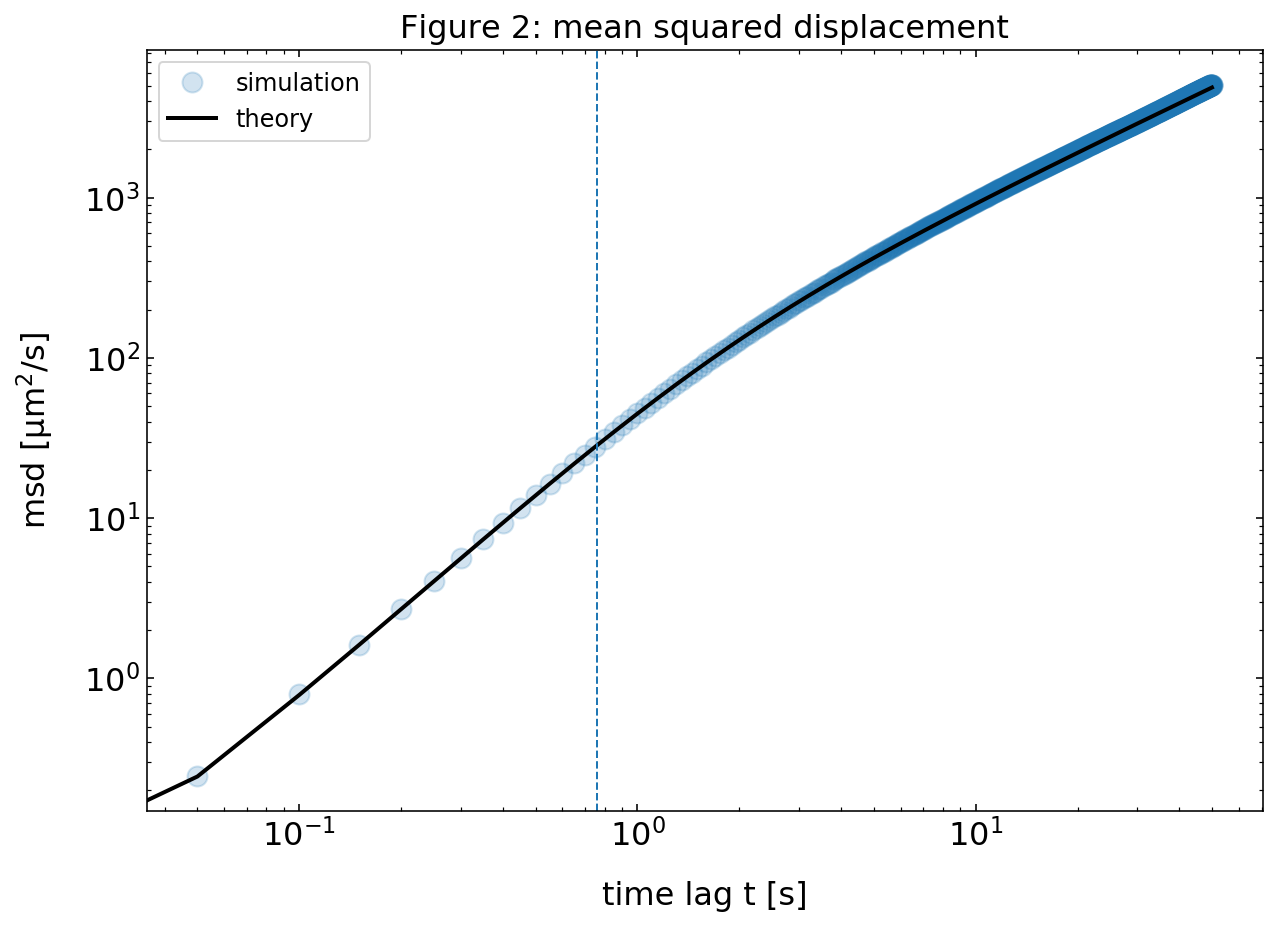

In [729]:
plt.figure(figsize=(10,7))
plt.loglog(time,MSD,'o',label='simulation',ms=10,alpha=0.2)
msd_theo=(4*D+2*v**2/Dr)*time+2*v**2/Dr**2*(np.exp(-time*Dr)-1)
plt.loglog(time,msd_theo,'k-',label='theory',lw=2)
plt.axvline(x=1/Dr,ls='--')
plt.xlabel('time lag t [s]')
plt.ylabel('msd [µm$^2$/s]')
plt.title('Figure 2: mean squared displacement')
plt.legend()
plt.show()

### 1.3 Active Particle Displacement Analysis in the Particle Frame

The reason for the special shape of the displacement statistics is the diffusing velocity vector of the active particle in the lab frame. The velocity vector is bound to the particle orientation. To recover the Gaussian statistics one needs to analyze the particle displacements in the center of mass frame along or perpendicular to the particle orientation. The projection of the displament to the particle orientation results in a shifted Gaussian, with a mean value giving the active particle velocity and the width of the Gaussian, which is defined by the diffusion coefficient. Actually, this seems to be obvious at first glance, but our intuition is led by our experience from equilibrium physics. A Gaussian statistics in not necessarily valid for the non-equilibrium situation of the active particle here. Besides the displacement in the direction parallel to the particle orientation, we may obtain
the displacement statistics perpendicular to the particle orientation. As this motion is perpendicular to the propulsion direction, the results shall be a Gaussian with a width corresponding to the diffusion coefficient.





In [55]:
# generate a list of unit vectors in the direction of the particle velocity
uvec_par=np.array([np.cos(dff.angle),-np.sin(dff.angle)])[:,:-1]

# generate a list of unit vectors in the direction perpendicular to the particle velocity
uvec_perp=np.array([np.cos(dff.angle+np.pi/2),-np.sin(dff.angle+np.pi/2)])[:,:-1]

# generate a list of displacement vectors
dr=np.array([dff.x.diff(1).dropna().values,dff.y.diff(1).dropna().values])

# project the displacements on the unit vectors along the propulsion direction
proj_par=np.sum(uvec_par*dr,axis=0)

# project the displacements on the unit vectors perpendicular to the propulsion direction
proj_perp=np.sum(uvec_perp*dr,axis=0)

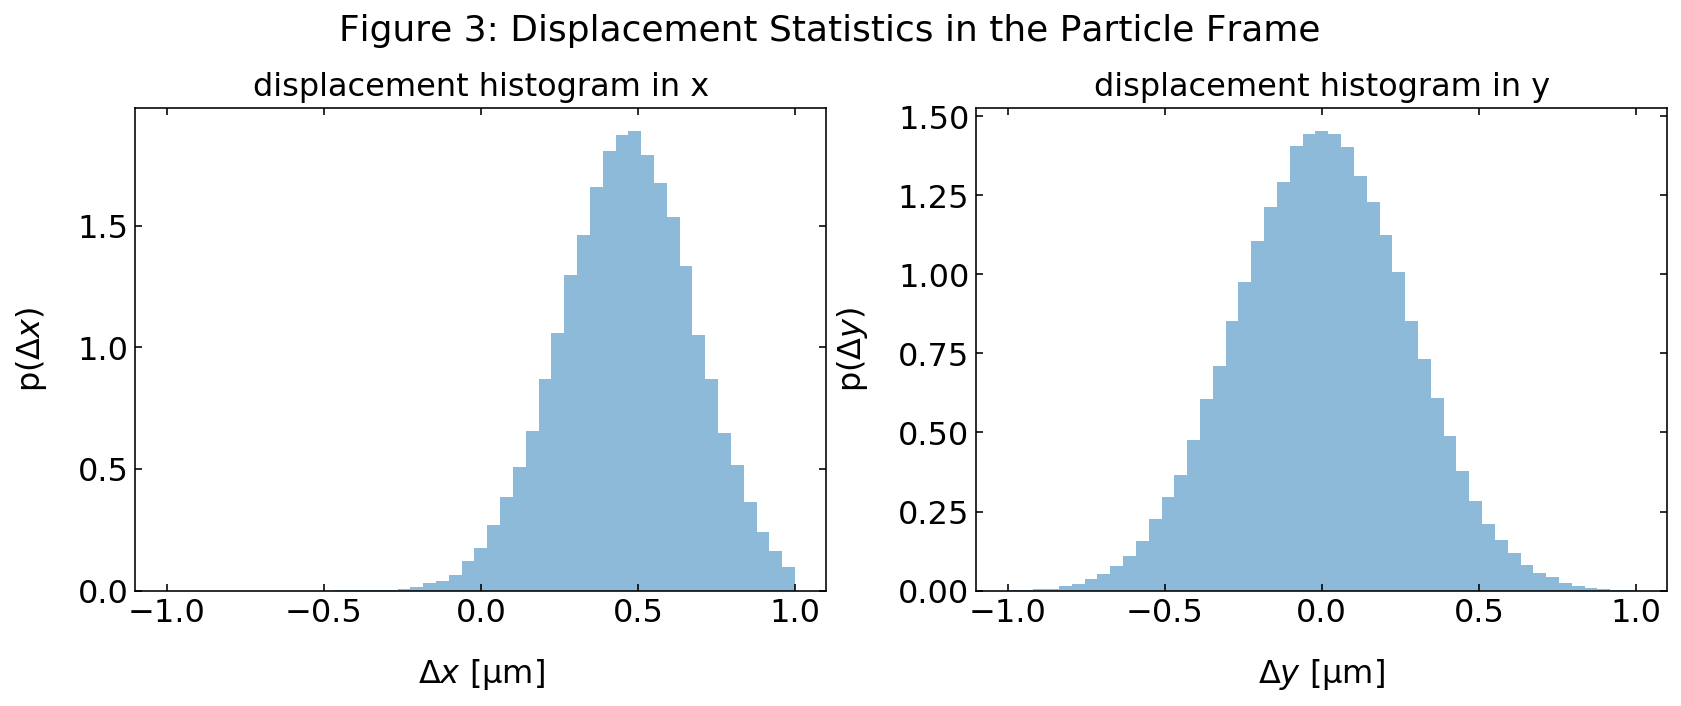

In [56]:
from scipy.stats import norm
xx=np.linspace(-1,1,50)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.hist(proj_par,bins=xx,alpha=0.5,density=True)
plt.title('displacement histogram in x')
plt.xlabel('$\Delta x$ [µm]')
plt.ylabel('p($\Delta x$)')
#plt.plot(xx, norm.pdf(xx,np.mean(proj_par),np.var(proj_par)/2/dt/np.sqrt(2)))


plt.subplot(1,2,2)
plt.hist(proj_perp,bins=xx,alpha=0.5,density=True)
plt.title('displacement histogram in y')
plt.xlabel('$\Delta y$ [µm]')
plt.ylabel('p($\Delta y$)')
#plt.plot(xx, norm.pdf(xx,np.mean(proj_perp),np.var(proj_perp)/2/dt/np.sqrt(2)))

plt.suptitle('Figure 3: Displacement Statistics in the Particle Frame',fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

plt.show()

## 2. Photon Nudging

Photon nudging  correlates the orientation of the active particle with its activity. The particle propulsion is only switched on, if the particle is oriented towards a target position. Otherwise the particle is just carrying out rotation and translational diffusion. It is similar to the run and tumble motion of bacteria, however, the tumbling motion is not active, but purely driven by thermal fluctuations. 


![nudging.png](nudging.png)


#### Experimental Information

The experimental realization of this procedure involves the observation of Janus type particles in a dark field microscopy setup. The dark field is allow for a background free optical detection. The different optical constants of the gold hemisphere and the polymer side of a Janus particle create an anisotropic image, which allows the identification of the orienation of the particle. When this orientation is determined in real time the laser heating the particle can be positioned and switched with an acousto optic deflector (AOD) at the particle position.

![experimental_setup.png](experimental_setup.png)

### 2.1 Photon Nudging Particle Motion in the Lab Frame

The function below generates a single trajectory of an active particle being photon nudged towards a target position. The function takes the number of simulation steps $N$, the translation diffusion coefficient $D$, the rotational diffusion coefficient $D_{r}$, the velocity $v$, the acceptance angle $\beta$, the target position ${\bf t}$ and the time step $\Delta t$. It returns a pandas dataframe with the position of the particle, the frame number, the angle and the nudging state.

In [714]:
# generate the data of an photon nudging particle random walk
def genData_nudge(N,_D,_Dr,_v,_beta,_tar,_dt):
    v=np.random.random(2)
    v[0]=_v
    v[1]=0
    sigma=np.sqrt(2*_D*dt)
    sigma_r=np.sqrt(2*_Dr*dt)

    phi=sigma_r*randn(N).cumsum()
    vx,vy=[np.zeros(N),np.zeros(N)]
    vx[:],vy[:]=[v[0],v[1]]
    vv=np.array([rotate([vx[i],vy[i]],phi[i]) for i in range(len(phi))])
    
    #do the random walk
    x=np.zeros(len(vv))
    x[0]=-10
    y=np.zeros(len(vv))
    nudge=np.zeros(len(vv))
    for i in range(1,len(vv)):
        #get the direction to the target
        dx=_tar[0]-x[i-1]
        dy=_tar[1]-y[i-1]
        length=np.sqrt(dx**2+dy**2)        
        dx=dx/length
        dy=dy/length
        #get the direction of motion
        length_v=np.sqrt(vv[i-1][0]**2+vv[i-1][1]**2)
        direction=vv[i-1]/length_v
        angle=np.arccos(np.dot([dx,dy],direction))
        if angle<_beta:
            x[i]=x[i-1]+(sigma*randn()+vv[i-1,0]*dt)
            y[i]=y[i-1]+(sigma*randn()+vv[i-1,1]*dt)
            nudge[i]=1
        else:
            x[i]=x[i-1]+sigma*randn()
            y[i]=y[i-1]+sigma*randn()
    
    index=[i for i in range(N)]
    df=pd.DataFrame({'x':x,'y':y,'frame': index,'angle': phi,'nudge': nudge})
    return(df)

The following parameters are used for the photon nudging trajectory simulation.

#### Setting the Simulation Parameters

In [739]:
dt=0.05  # 50 ms time resolution
a=0.5e-6  # particle radius
eta=1e-3  # viscosity of water
v=8  #  µm/s velocity
D=D_T(eta,a)*1e12   # µm^2/s diffusion coefficient
Dr=D_R(eta,a)   # 0.1 rad^2/s rotational diffusion
N=100000 # number of steps
target= [0.1,0.1]
beta=np.pi/3

dff=genData_nudge(N,D,Dr,v,beta,target,dt)


#### Trajectory and Displacement Statistics

The graphs below show 100000 trajectory points coming of the active particle given for the parameters above. The displacement historgrams in the x and y-direction are plotted for a time lag of one frame (or dt) in real units.

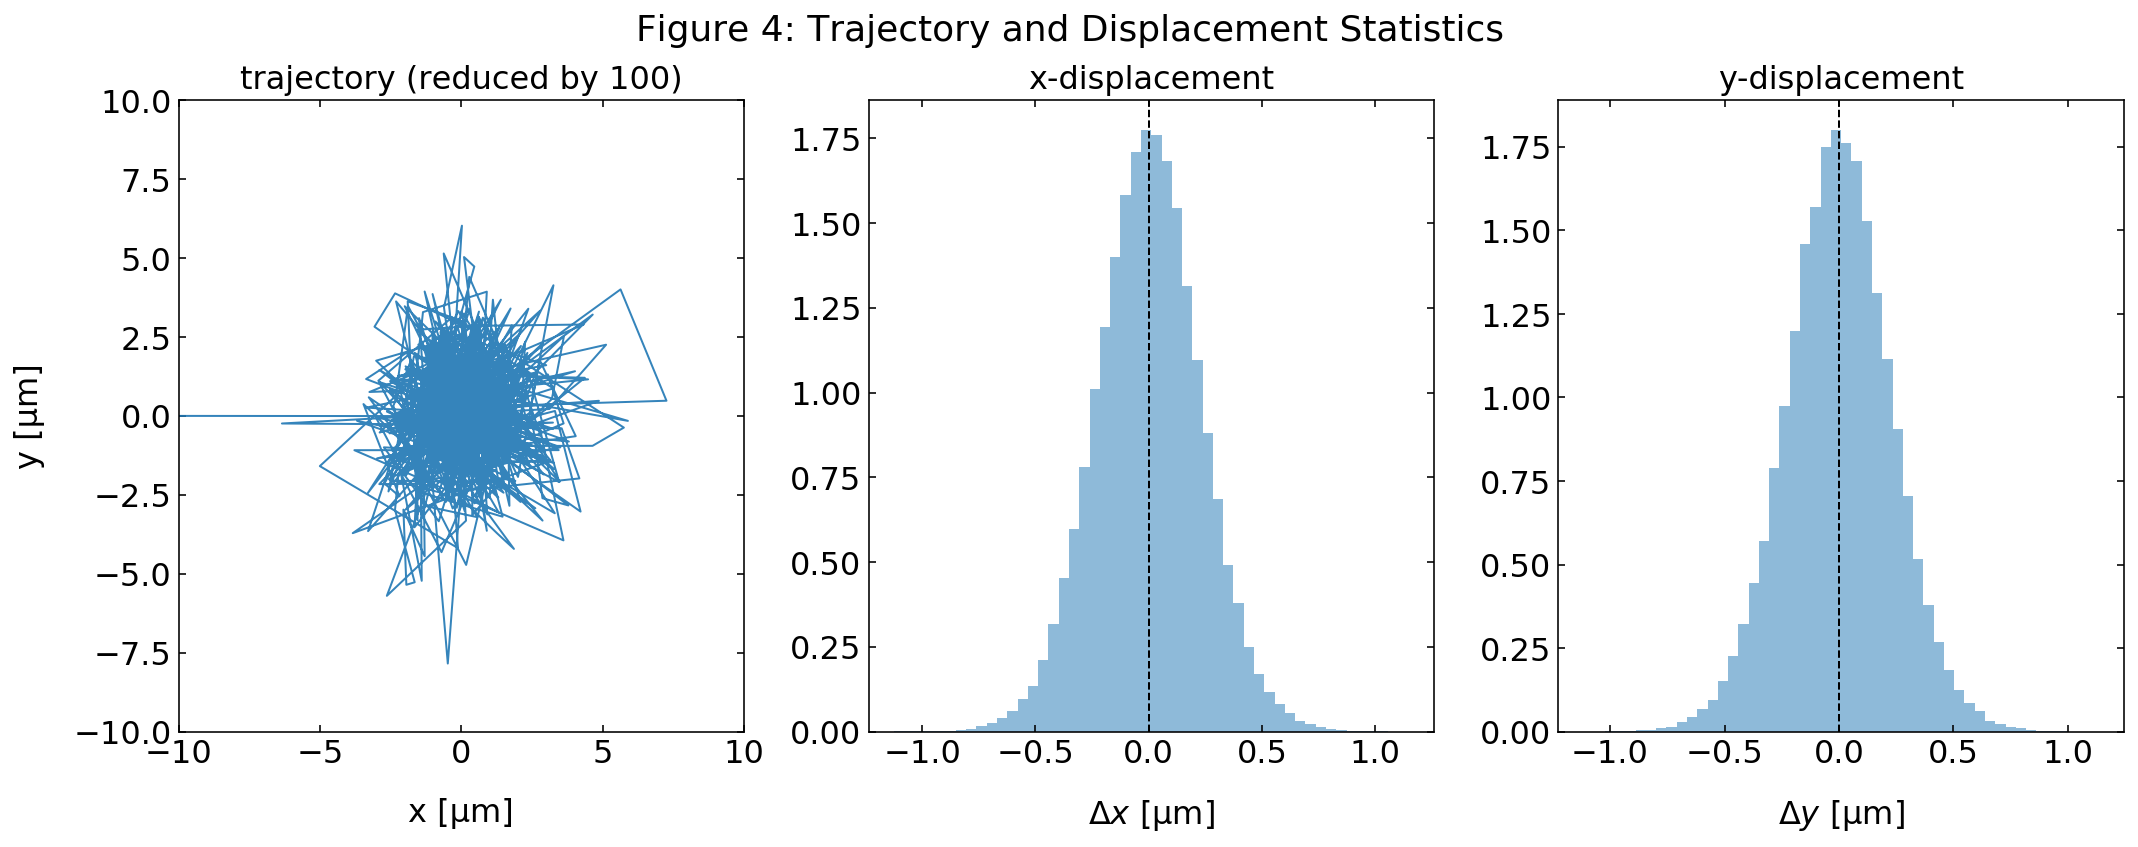

In [740]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.plot(dff['x'][:100000:100],dff['y'][:100000:100],'-',alpha=0.9)
plt.title('trajectory (reduced by 100)')
plt.xlabel('x [µm]')
plt.ylabel('y [µm]')
plt.xlim(-10,10)
plt.ylim(-10,10)

plt.subplot(1,3,2)
dff.x.diff(1).hist(bins=50,alpha=0.5,grid=False,density=True)
plt.xlabel('$\Delta x$ [µm]')
plt.axvline(x=dff.x.diff(1).mean(),ls='--',color='k',lw=1)
plt.title('x-displacement')

plt.subplot(1,3,3)
dff.y.diff(1).hist(bins=50,alpha=0.5,grid=False,density=True)
plt.xlabel('$\Delta y$ [µm]')
plt.axvline(x=dff.y.diff(1).mean(),ls='--',color='k',lw=1)
plt.title('y-displacement')

plt.suptitle('Figure 4: Trajectory and Displacement Statistics',fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.88)

plt.show()

#### Mean Squared Displacement

The mean squared displacement for the active particle which photon nudged towards a specific target position is showing the typical saturation behavior due t the fact that the particle cannot escape the region of the target position.

In [741]:
time,MSD=msd(dff,dt,5000)

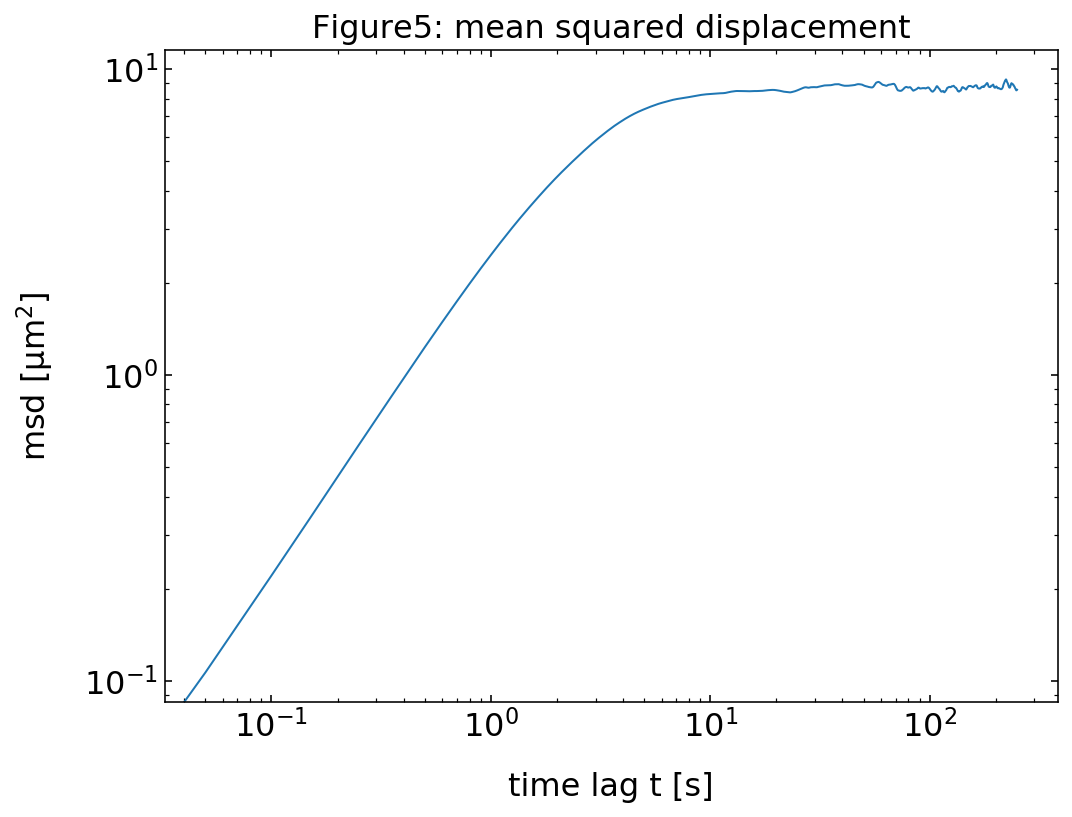

In [743]:
plt.figure(figsize=(8,6))
plt.loglog(time,MSD)
#msd_theo=(4*D+2*v**2/Dr)*time+2*v**2/Dr**2*(np.exp(-time*Dr)-1)
#plt.loglog(time,msd_theo,'k-',label='theory',lw=2)
plt.xlabel('time lag t [s]')
plt.ylabel('msd [µm$^2$]')
plt.title('Figure5: mean squared displacement')
plt.show()

### 2.2 Nudging Statistics

In the simplest case of photon nudging, the laser is switched on at a constant intensity according to its orientation with respect to the target. This results in a Janus particle velocity $v(t)=v_{\rm th}h(t)$.
The function $h(t)$ is a random telegraph signal.

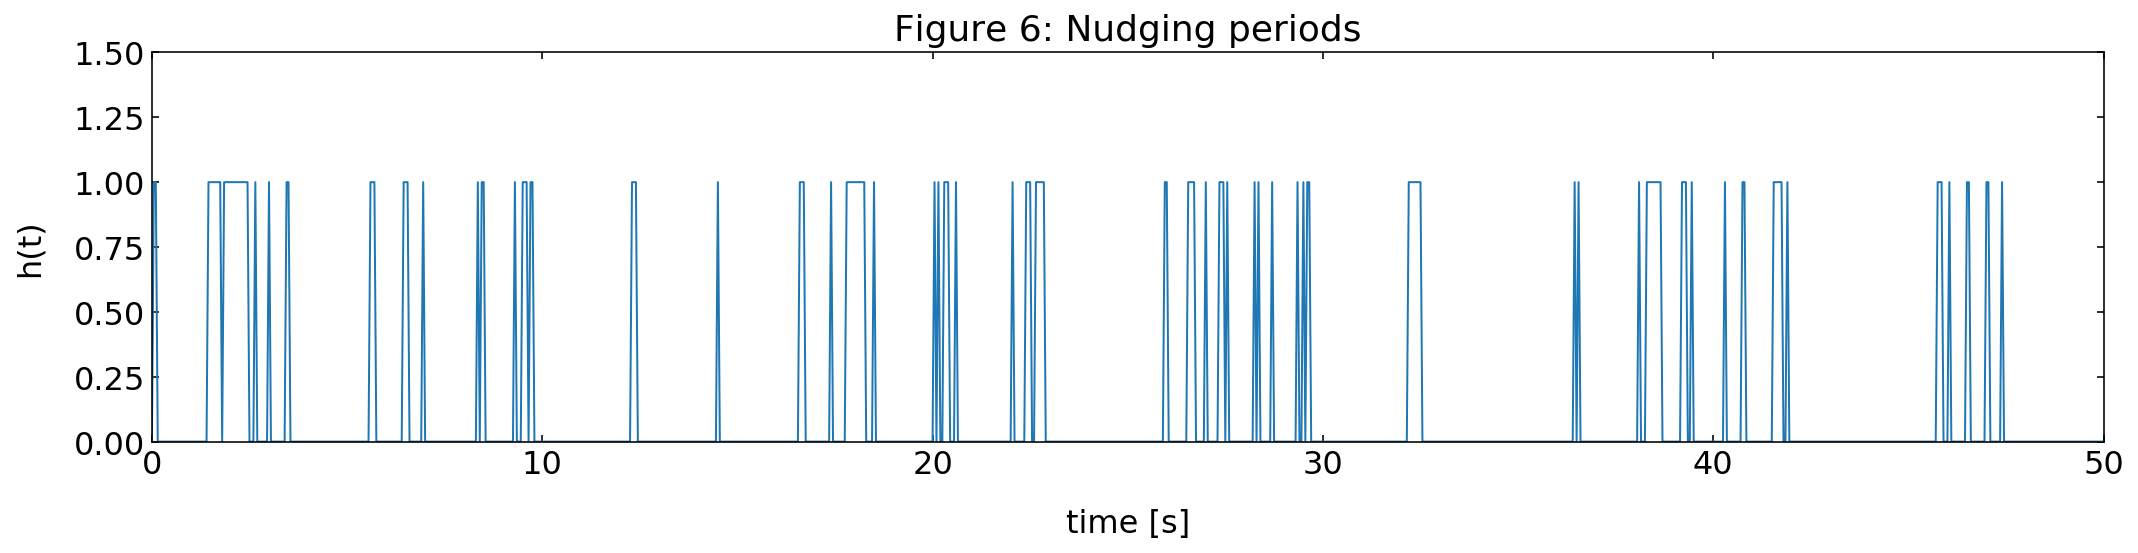

In [747]:
plt.figure(figsize=(15,4))
plt.plot(np.array(range(len(dff.nudge)))*dt,dff.nudge)
plt.xlim(0,50)
plt.ylim(0,1.5)
plt.xlabel('time [s]')
plt.ylabel('h(t)')

plt.title('Figure 6: Nudging periods',fontsize=18)
plt.tight_layout()

plt.show()

With the help of the data when the laser for the photon nudging has been switched on, we are able to calculate the duty fraction for the particle, which is the total *on* time devided by the total time or the average *on* time $\bar{t}_{\rm on}$ devided by the sum of average *on* and *off* time $\bar{t}_{\rm on}+\bar{t}_{\rm off}$.

\begin{equation}
f_{t}=\frac{\bar{t}_{\rm on}}{\bar{t}_{\rm on}+\bar{t}_{\rm off}}
\end{equation}

A typical value of the duty fraction is $f_{t}=0.1$.

Besides this duty fraction, there is also a geometrical factor, which arises from the finite acceptance angle. Due to the finite acceptance angle, the average radial velocity of the swimmer is smaller than the actual thermophoretic velocity $v_{\rm th}$. It is the angular velocity averaged over the acceptance angle and results in 2 dimensions in

\begin{equation}
f_{r}=\frac{\sin(\beta)}{\beta}
\end{equation}

A typical value for this geometrical factor is around $f_{r}=0.7$. 
Both parameters finally contribute to the effective radial velocity that confines the particle within photon nudging, i.e. in 2D:

\begin{equation}
v_{\rho}=f_{r}f_{t}v_{th}
\end{equation}


For the given parameters of the simulation, the duty fraction are found by

In [745]:
ft=np.sum(dff.nudge)/len(dff.nudge)
fr=np.sin(beta)/beta
print(r'duty fraction',ft)
print(r'geometrical factor',fr)
print(r'radial velocity',fr*ft*v)

duty fraction 0.11347
geometrical factor 0.8269933431326881
radial velocity 0.7507114771621289


### 2.3 Photon Nudging Density Distributions

The steady state probability density of finding an active Janus particle of radial velocity $v_{\rho}$,  diffusion coefficient $D$ and a distance $\rho$ from the center is given by

\begin{equation}
p(\rho)=\frac{v_{\rho}^2}{D^2}e^{-\frac{v_{\rho}}{D}\rho}
\end{equation}

in two dimensions. This is the result of a simple consideration, that the photon nudging causes a radial drift velocity of the Janus particles $v_{\rho}$ towards the target. The drift would cause and enhanced probability for finding the particle at the target, which in turn causes a diffusion drift away from the target. The balance of the two probability density currents gives the density distribution above for this *sedimentation* problem. The above formula can be derived for a constant radial velocity $v_{\rho}$ and an infinite time resolution, i.e. the displacements due to the velocity and diffusion are infinitely small.

In [705]:
# calculate an in 2D probability density distribution 
def p_image(_x,_y,_v,_D):
    X,Y=np.meshgrid(_x,_y)
    rho=np.sqrt(X**2+Y**2)
    p_ss=np.exp(-rho*_v/_D)
    return(p_ss)
    
# calculate the radial density distribution    
def p_rho(_rho,_v,_D):
    p_ss=_v**2/_D**2*np.exp(-_rho*_v/_D)
    return(p_ss)    


The velocity dependence of the theoretical position distribution for infinite time resolution is shown below.

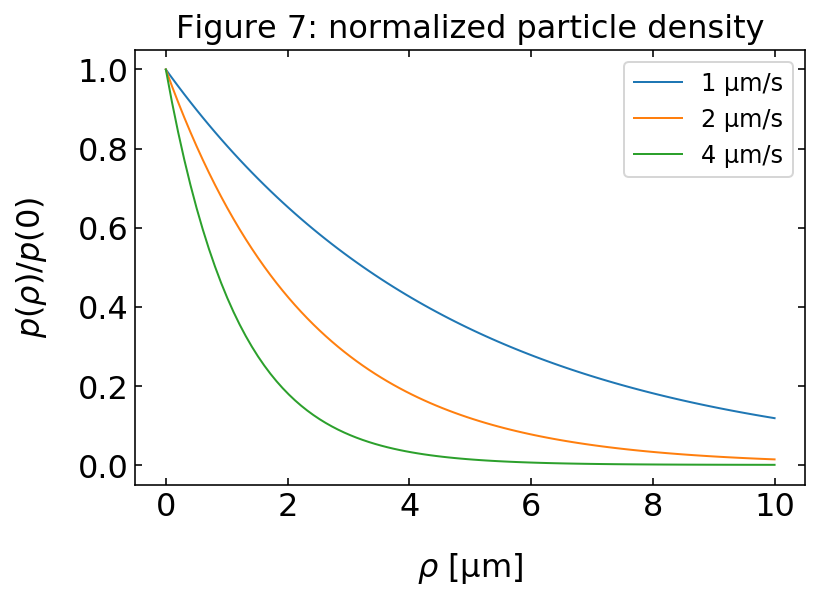

In [748]:
rho=np.linspace(0,10,100)

plt.plot(rho,p_rho(rho,fr*ft*1,D)/p_rho(rho,fr*ft*1,D)[0],label="1 µm/s")
plt.plot(rho,p_rho(rho,fr*ft*2,D)/p_rho(rho,fr*ft*2,D)[0],label="2 µm/s")
plt.plot(rho,p_rho(rho,fr*ft*4,D)/p_rho(rho,fr*ft*4,D)[0],label="4 µm/s")
plt.title('Figure 7: normalized particle density')

plt.legend()
plt.xlabel(r'$\rho$ [µm]')
plt.ylabel(r'$p(\rho)/p(0)$')
plt.show()

The position distribution of the particle around the target position can be compared to the theoretical prediction from the above mentioned sedimentation solution. Note that the localization only depends on the velocity and the diffusion coefficient. The plot below shows the comparison of the simulation and the theory with an additional *cheating factor (1.7)* for the radial velocity. The exact expression for the radial probability distribution is more complex due to various geometrical effects and the fact that the experiments have a finite time resolution. 

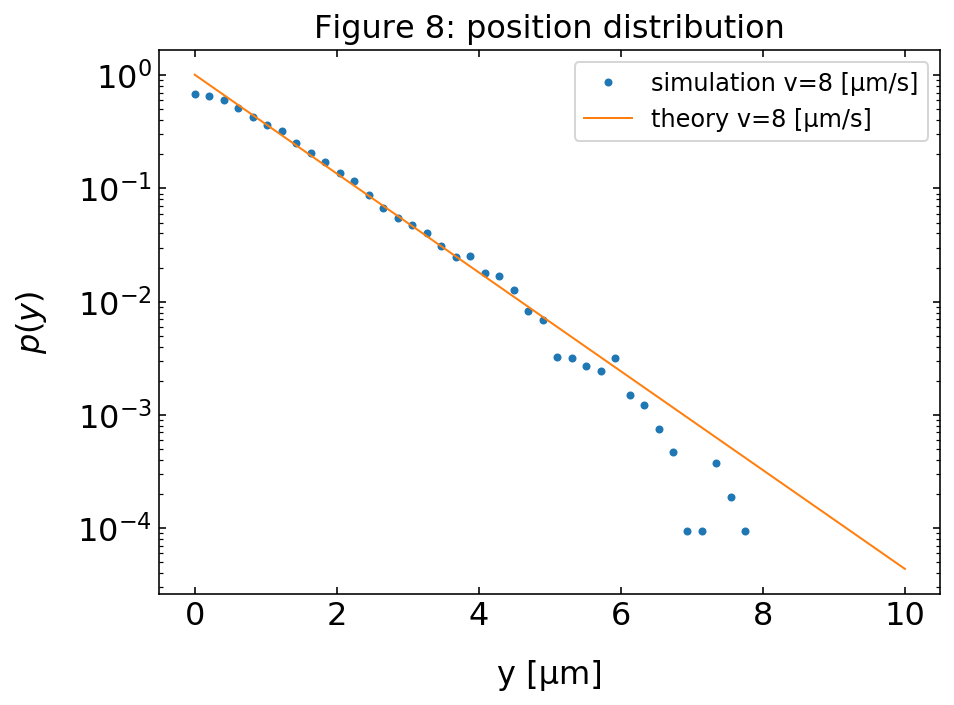

In [749]:
plt.figure(figsize=(7,5))
bins=np.linspace(0,10,50)
n,bin=np.histogram(dff['y'],bins=bins,density=True)
plt.plot(bins[:-1],n,'o',label='simulation v={0:1.0f} [µm/s]'.format(v))
plt.xlabel('y [µm]')
plt.ylabel('$p(y)$')
plt.semilogy(bins,p_rho(bins,ft*fr*v/1.7,D),label='theory v={0:1.0f} [µm/s]'.format(v))
plt.legend()

plt.title('Figure 8: position distribution')
plt.show()

In [708]:
xe=np.linspace(-5,5,50)
ye=np.linspace(-5,5,50)

# calculate the 2d position distribution 
p_i=p_image(xe,ye,fr*ft*v,D)

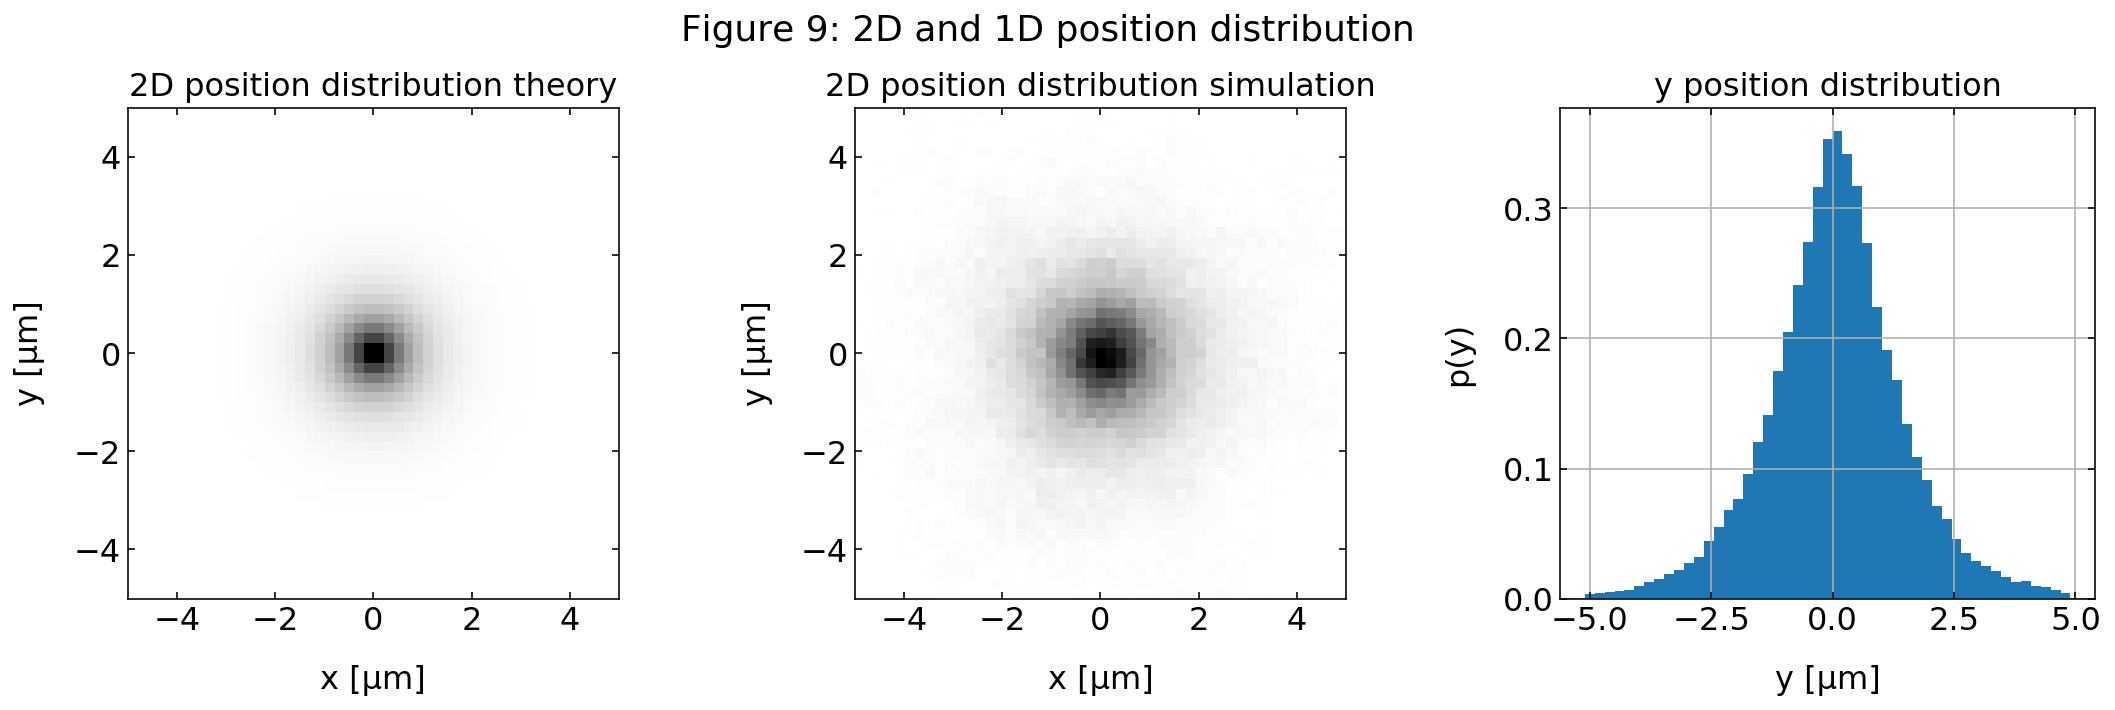

In [750]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
xe=np.linspace(-5,5,50)
ye=np.linspace(-5,5,50)

plt.imshow(p_i,extent=(xe.min(),xe.max(),ye.min(),ye.max()),cmap='gray_r')
plt.title('2D position distribution theory')
plt.xlabel('x [µm]')
plt.ylabel('y [µm]')


plt.subplot(1,3,2)
xe=np.linspace(-5,5,50)
ye=np.linspace(-5,5,50)
n,x,y=np.histogram2d(dff.x,dff.y,bins=[xe,ye])
plt.imshow(n,extent=(xe.min(),xe.max(),ye.min(),ye.max()),cmap='gray_r')
plt.title('2D position distribution simulation')
plt.xlabel('x [µm]')
plt.ylabel('y [µm]')

plt.subplot(1,3,3)
dy=(ye[1]-ye[0])/2
dff['y'].hist(bins=ye-dy,density=True)
plt.title('y position distribution')
plt.xlabel('y [µm]')
plt.ylabel('p(y)')

plt.suptitle('Figure 9: 2D and 1D position distribution',fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.85)

plt.show()

#### Effective Radial Velocity

The finite time resolution in the simulation and the experiment modifies for example the radial velocity field. When appraoching the target, the negative radial velocity increases and finally gets positive. This effective radial velocity is calculated below from the simulations by projecting the displacements between two frames on to the radial direction. This change in sign happens at a critical radius $R_{c}$.

![nudging_overshoot.png](nudging_overshoot.png)

In [710]:
# normalize the distances from the target to get the radial vector
d=np.sqrt(dff.x**2+dff.y**2)
dir_x=dff.x/d
dir_y=dff.y/d

# use only distances when the particle is nudged
dis=d[dff.nudge==1]

# project the displacement to the radial directon
proj=dff.x.diff(1)*dir_x+dff.y.diff(1)*dir_y

# use only projections when the particle is nudged
projs=proj[dff.nudge==1]

distance=[]
velocity=[]
drho=0.2
for w in np.arange(0,5,drho):
    distance.append(w)
    velocity.append(projs[np.logical_and(d<w+drho, d>w)].mean())

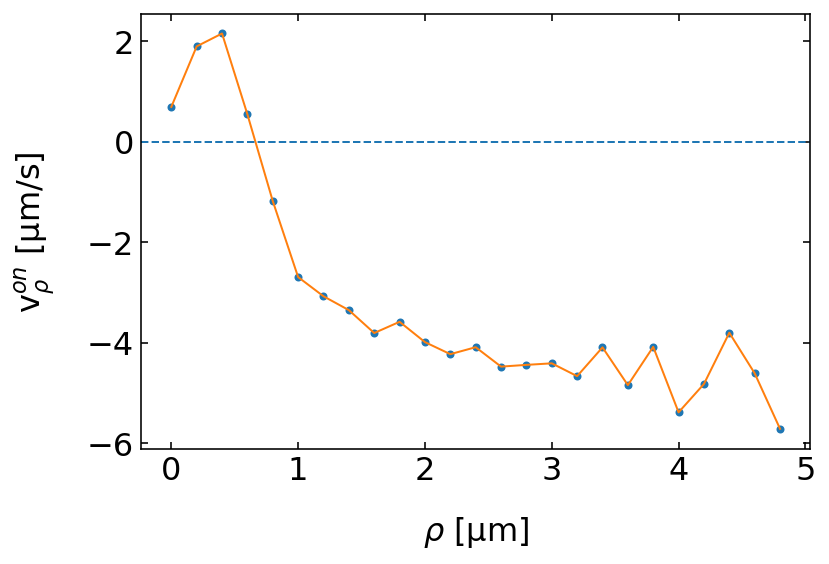

In [713]:
plt.plot(distance,np.array(velocity)/dt,'o')
plt.plot(distance,np.array(velocity)/dt,'-')
plt.axhline(y=0,ls='--')
#plt.axvline(x=v*dt/(2*np.cos(beta)),ls='--')
#plt.title('2d radial velocity profile')
plt.xlabel(r'$\rho$ [µm]')
plt.ylabel(r'v$_{\rho}^{on}$ [µm/s]')
plt.show()

#### Virtual Effective Potential


The probability density for finding a particle in space as produced by photon nudging in its simplest form above can be also achieved with a potential in thermal equilibrium. The potential which would cause the same distribution of particles can be calculated from the particle probability density distribution by 

\begin{equation}
U_{\rm eff}(x)=-k_{B}T \ln(p(x))
\end{equation}

This potential, however does not exist in photon nudging case. The distribution is caused by a radial drift field, which also only exists in the time average. The corresponding thermal equilibrium potential is thus named *virtual effective potential*. Inserting the infinite time resolution results in a linear cone shaoed potential with a linear increase from the origin.

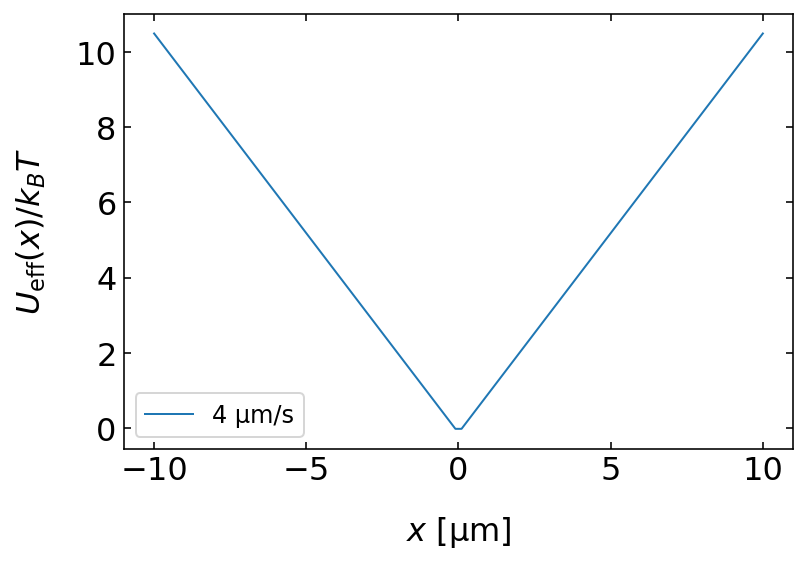

In [689]:
x=np.linspace(-10,10,100)

plt.plot(x,-np.log(p_rho(np.abs(x),fr*ft*4,D)),label="4 µm/s")

plt.legend()
plt.xlabel(r'$x$ [µm]')
plt.ylabel(r'$U_{\rm eff}(x)/k_{B}T$')
plt.show()

## 3. Artificial Binding of Symmetric Particles


to be updated ...